In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from io import StringIO
import io

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.constants import G, h, k_B

h = 0.6774
cosmo = FlatLambdaCDM(H0= (h * 100) * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

#imported requests
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}

Define get:

In [16]:
#preliminary definitions
#defined get()
def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

Define SFH_get to get histogram of SFR:

In [17]:
#input params: redshift==numerical-val; id==int(must exist in range, pre-check); plot=="True" or "False"
#output: (plot=False): (SFH, BE): SFH=StellarFormationHistory, BE=BinEdges
#output: (plot=True): plt.hist (SFH, BE)
def SFH_get(redshift, id, plot=False, binwidth=0.05): 
    
    import h5py
    params = {'stars':'GFM_StellarFormationTime,GFM_InitialMass'}
#if exists, load it. If does not exist, download it
    from pathlib import Path

    if Path('cutout_'+str(id)+'.hdf5').is_file():
        saved_filename = 'cutout_'+str(id)+'.hdf5'
        #print ("File exist") #extract if exists
        with h5py.File(saved_filename, mode='r') as f: #store as h5py file
            starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
            starInitialMass = f['PartType4']['GFM_InitialMass'][:]
    else:
        #print ("File not exist") #download and extract if does not exist
        url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
        sub = get(url) # get json response of subhalo properties
        saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
    
        with h5py.File(saved_filename, mode='r') as f: #store as h5py file
            starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
            starInitialMass = f['PartType4']['GFM_InitialMass'][:]
        
    
    z_starFormationTime = 1/starFormationTime -1
    Gyr_starFormationTime = cosmo.age(z_starFormationTime).value
    M_Odot_starInitialMass = starInitialMass*1e10/h 
    Gyr_redshift = cosmo.age(2.0).value
    HistWeights = M_Odot_starInitialMass/(binwidth*1e9)
    LookbackTime = Gyr_redshift - Gyr_starFormationTime
    
    if plot==False:
        return np.histogram(LookbackTime, bins=np.arange(min(Gyr_redshift - Gyr_starFormationTime), max(Gyr_redshift - Gyr_starFormationTime) + binwidth, binwidth), weights=(HistWeights))
    
    else:
        SFH, BE = np.histogram(LookbackTime, bins=np.arange(min(Gyr_redshift - Gyr_starFormationTime), max(Gyr_redshift - Gyr_starFormationTime) + binwidth, binwidth), weights=(HistWeights))
        bincenters = [(BE[i]+BE[i+1])/2. for i in range(len(BE)-1)]
        plt.figure(figsize=(10,7))
        plt.step(bincenters, SFH, color = 'b')
        plt.title('Histogram for Lookback Times for id = ' + str(id))
        plt.xlim(0, Gyr_redshift)
        plt.ylim(0, )
        plt.xlabel("Lookback Time (Gyr)")
        plt.ylabel("$M_\odot$/yr")
        plt.show()
        return plt.show()

Finding ids at given redshift and mass-range:

In [18]:
#set redshift
redshift = 2.0
#select for mass range
mass_min = 10**10.5 / 1e10 * h
#mass_max = 10**12 / 1e10 * h

# form the search_query string by hand for once
search_query = "?mass_stars__gt=" + str(mass_min) #+ "&mass_stars__lt=" + str(mass_max)

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + search_query

subhalos = get(url, {'limit':5000})
#subhalos['count']==1045
ids = [ subhalos['results'][i]['id'] for i in range(subhalos['count'])]

Define Mean_SFT to get mean SFT:

In [19]:
#input params: z=redshift (num val); subhalo_id==int(must exist in range, pre-check)
#dependent on SFH_get(plot=False) output
#output: MeanStellarAge, in units of Gyr
def Mean_SFT(z, subhalo_id):
    SFH, BE = SFH_get(redshift = z, id = subhalo_id)
    MeanStellarAge = np.sum([(SFH[i]*1e9)*BE[i] for i in range(len(SFH))])/sum(SFH*1e9)
    
    return MeanStellarAge
#opt return: print("Mean Stellar Age for subhalo with id=" +str(subhalo_id)+ " at redshift " + str(z) + " is " + str(MeanStellarAge) + " Gyr")

Define TimeAvg_SFR to get average SFR over a given timescale:

In [23]:
#input params: z=redshift(num val); subhalo_id==int(must exist in range, pre-check); timescale=num val in range(LT) in units of Gyr
#dependent on get_SFH(plot=False) output
#output: TimeAvg_SFR in units of $M_\odot$/yr
def TimeAvg_SFR(z, subhalo_id, timescale):
    SFH, BE = SFH_get(redshift = z, id = subhalo_id, plot=False)
    if timescale<BE[0]:
        TimeAvg_SFR = SFH[0]
    else:
        timescale_indices = np.where(BE<=timescale)
        TimeAvg_SFR = np.sum([SFH[i] for i in timescale_indices])/len(timescale_indices[0])
        #NOTE: floored bin value, change to SFH[i+1] for ceiling
    return TimeAvg_SFR

Define Median_SFT to get median age of galaxy:

In [21]:
#input params: z=redshift (num val); subhalo_id==int(must exist in range, pre-check)
#dependent on SFH_get(plot=False) output
#output: MedianStellarAge = a Bin Edge in units of Gyr
def Median_SFT(z, subhalo_id):

    SFH, BE = SFH_get(redshift = z, id = subhalo_id)
    total = [(SFH[i]*1e9)*BE[i] for i in range(len(SFH))] #arr
    tot_sum = (0.5 * np.sum(total))
    cumsum_median = np.cumsum(total) < tot_sum #filter_arr
    newarr = np.cumsum(total)[cumsum_median]
    
    return BE[len(newarr)-1] #units: Gyr in Lookback time

Get mean SFT, time avg SFR, current SFR and median SFT data:

In [8]:
#create and populate array for mean SFT
means = np.zeros(subhalos['count'])

for i, id in enumerate(ids[:subhalos['count']]): #need to know # of elements to implement #append is slower
    means[i] = Mean_SFT(z=2.0, subhalo_id=id)

In [12]:
#save file for mean SFT
np.savetxt('z=2_Mean_SFT', means)

In [28]:
#create and populate arrays for time avg SFR, current SFR, median SFT
time_averages = np.zeros(subhalos['count'])
current_SFRs = np.zeros(subhalos['count'])
medians = np.zeros(subhalos['count'])

for i, id in enumerate(ids[:subhalos['count']]): #need to know # of elements to implement #append is slower
    time_averages[i] = TimeAvg_SFR(z=2.0, subhalo_id=id, timescale=1.0)
    current_SFRs[i] = TimeAvg_SFR(z=2.0, subhalo_id=id, timescale=0.0)
    medians[i] = Median_SFT(z=2.0, subhalo_id=id)

In [29]:
#save remaining files for time avg SFR, current SFR, median SFT
np.savetxt('z=2_TimeAvg_SFR_1Gyr', time_averages)
np.savetxt('z=2_Current_SFR', current_SFRs)
np.savetxt('z=2_Median_SFT', medians)

In [30]:
#call for Mean_SFT, TimeAvg_SFR_1Gyr, Current_SFR, Median_SFT
MeanSFT = np.loadtxt('z=2_Mean_SFT', dtype=float)
GyrAvgSFR = np.loadtxt('z=2_TimeAvg_SFR_1Gyr', dtype=float)
CurrentSFR = np.loadtxt('z=2_Current_SFR', dtype=float)
MedianSFT = np.loadtxt('z=2_Median_SFT', dtype=float)

Text(0, 0.5, 'Median Stellar Age (Gyr)')

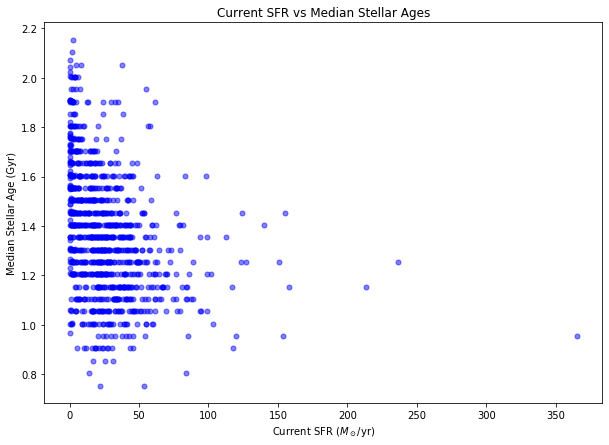

In [35]:
#plot for Current SFR vs Median Stellar Ages
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(CurrentSFR, MedianSFT, 'bo', ms=5, alpha=0.5)
plt.title('Current SFR vs Median Stellar Ages')
plt.xlabel('Current SFR ($M_\odot$/yr)')
plt.ylabel('Median Stellar Age (Gyr)')
#discrete mean SFTs since only bin edges are acceptable values.

Text(0, 0.5, 'Time-Averaged SFR over 1 Gyr of Lookback Time ($M_\\odot$/yr)')

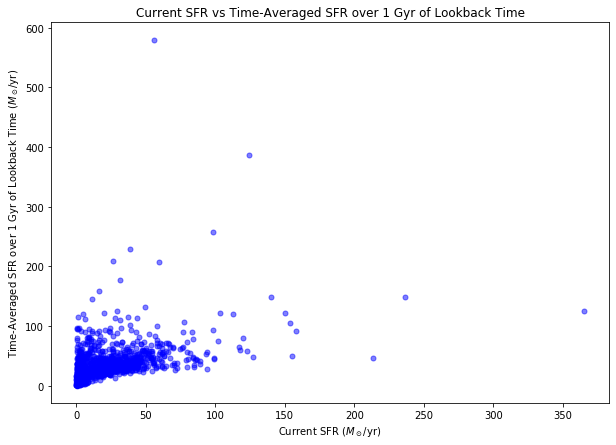

In [32]:
#plot for Current SFR vs Time-Averaged SFR over 1 Gyr of Lookback Time
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(CurrentSFR, GyrAvgSFR, 'bo', ms=5, alpha=0.5)
plt.title('Current SFR vs Time-Averaged SFR over 1 Gyr of Lookback Time')
plt.xlabel('Current SFR ($M_\odot$/yr)')
plt.ylabel('Time-Averaged SFR over 1 Gyr of Lookback Time ($M_\odot$/yr)')

Text(0, 0.5, 'Mean Stellar Age (Gyr)')

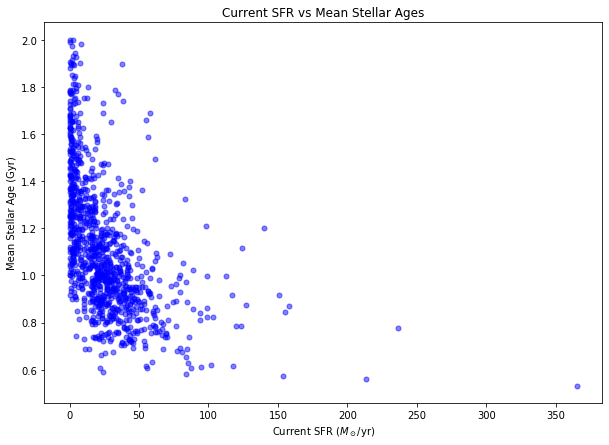

In [33]:
#plot for Current SFR vs Mean Stellar Ages
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(CurrentSFR, MeanSFT, 'bo', ms=5, alpha=0.5)
plt.title('Current SFR vs Mean Stellar Ages')
plt.xlabel('Current SFR ($M_\odot$/yr)')
plt.ylabel('Mean Stellar Age (Gyr)')

Text(0, 0.5, 'Time-Averaged SFR over 1 Gyr of Lookback Time ($M_\\odot$/yr)')

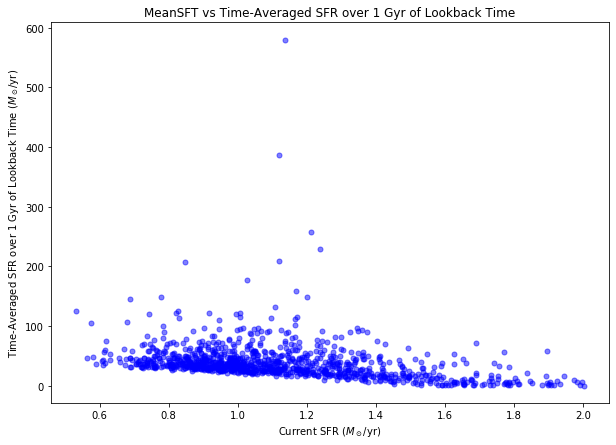

In [34]:
#plot for Mean Stellar Ages vs Time-Averaged SFR over 1 Gyr of Lookback Time
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(MeanSFT, GyrAvgSFR, 'bo', ms=5, alpha=0.5)
plt.title('MeanSFT vs Time-Averaged SFR over 1 Gyr of Lookback Time')
plt.xlabel('Current SFR ($M_\odot$/yr)')
plt.ylabel('Time-Averaged SFR over 1 Gyr of Lookback Time ($M_\odot$/yr)')